In [1]:
%config IPCompleter.greedy=True
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as matplot
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings("ignore")

from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,accuracy_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, validation_curve
from sklearn.preprocessing import LabelEncoder,normalize,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from logitboost import LogitBoost
from IPython.display import display, Image, SVG, Math, YouTubeVideo
from data_exploration import explore
from feature_engineering import transformation

# Outstanding Ploting

In [90]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.facecolor'] = (0.9,0.9,0.9)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'w'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['legend.fontsize'] = 22
mpl.rcParams['legend.facecolor'] = [1,1,1]
mpl.rcParams['legend.framealpha'] = 0.75
mpl.rcParams['axes.labelsize'] = 22

## Preprocessing (transformation/scaling)

In [2]:
test = pd.read_csv('UNSW_NB15_training-set.csv')
train = pd.read_csv('UNSW_NB15_testing-set.csv')

In [3]:
combined_data_1 = pd.concat([train, test]).drop(['id'],axis=1)

In [4]:
train = train.where(train['service'] == "http").dropna()
test = test.where(test['service'] == "http").dropna()

In [5]:
combined_data = pd.concat([train, test]).drop(['id'],axis=1)

In [6]:
combined_data.shape

(27011, 44)

In [7]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27011 entries, 35 to 175214
Data columns (total 44 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                27011 non-null  float64
 1   proto              27011 non-null  object 
 2   service            27011 non-null  object 
 3   state              27011 non-null  object 
 4   spkts              27011 non-null  float64
 5   dpkts              27011 non-null  float64
 6   sbytes             27011 non-null  float64
 7   dbytes             27011 non-null  float64
 8   rate               27011 non-null  float64
 9   sttl               27011 non-null  float64
 10  dttl               27011 non-null  float64
 11  sload              27011 non-null  float64
 12  dload              27011 non-null  float64
 13  sloss              27011 non-null  float64
 14  dloss              27011 non-null  float64
 15  sinpkt             27011 non-null  float64
 16  dinpkt             2

In [8]:
combined_data.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
35,0.983874,tcp,http,FIN,10.0,8.0,816.0,1172.0,17.278635,62.0,...,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,Normal,0.0
40,1.535254,tcp,http,FIN,10.0,10.0,826.0,1266.0,12.375802,62.0,...,1.0,2.0,0.0,0.0,1.0,1.0,3.0,0.0,Normal,0.0
45,1.059359,tcp,http,FIN,10.0,8.0,830.0,1134.0,16.047441,62.0,...,1.0,1.0,0.0,0.0,1.0,3.0,1.0,0.0,Normal,0.0
49,0.990548,tcp,http,FIN,10.0,10.0,804.0,1414.0,19.181301,62.0,...,1.0,2.0,0.0,0.0,1.0,1.0,2.0,0.0,Normal,0.0
72,1.303518,tcp,http,FIN,12.0,8.0,898.0,1120.0,14.575939,62.0,...,1.0,1.0,0.0,0.0,1.0,2.0,1.0,0.0,Normal,0.0


In [9]:
combined_data.tail()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
174998,0.279691,tcp,http,FIN,10.0,8.0,818.0,1956.0,60.781360,62.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,Exploits,1.0
175039,0.337651,tcp,http,FIN,10.0,12.0,814.0,7054.0,62.194393,62.0,...,1.0,1.0,0.0,0.0,1.0,34.0,1.0,0.0,Exploits,1.0
175076,0.363137,tcp,http,FIN,10.0,10.0,856.0,4732.0,52.321850,62.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,Exploits,1.0
175138,0.238607,tcp,http,FIN,10.0,6.0,922.0,268.0,62.864877,254.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,Reconnaissance,1.0
175214,0.989025,tcp,http,FIN,22.0,56.0,2424.0,68382.0,77.854453,62.0,...,1.0,1.0,0.0,0.0,1.0,21.0,1.0,0.0,Exploits,1.0


# Object --> Numerical Value (int 32)

In [10]:
tmp = train.where(train['attack_cat'] == "Normal").dropna()
len(tmp['attack_cat'])/len(train['attack_cat'])

0.48425244358634006

In [11]:
tmp = test.where(test['attack_cat'] == "Normal").dropna()
len(tmp['attack_cat'])/len(test['attack_cat'])

0.2856227301858577

In [12]:
le1 = LabelEncoder()
le = LabelEncoder()

vector = combined_data['attack_cat']

print("attack cat:", set(list(vector))) # use print to make it print on single line 

combined_data['attack_cat'] = le1.fit_transform(vector)
combined_data['proto'] = le.fit_transform(combined_data['proto'])
combined_data['service'] = le.fit_transform(combined_data['service'])
combined_data['state'] = le.fit_transform(combined_data['state'])

vector = combined_data['attack_cat']
print('\nDescribing attack_type: ')
print("min", vector.min())
print("max", vector.max())
print("mode",vector.mode())

attack cat: {'Exploits', 'DoS', 'Normal', 'Generic', 'Worms', 'Analysis', 'Reconnaissance', 'Fuzzers', 'Backdoor'}

Describing attack_type: 
min 0
max 8
mode 0    3
dtype: int32


In [13]:
print("mode", len(np.where(vector.values==6)[0])/len(vector))

mode 0.34656251156936063


In [15]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True  positive  = ', cm[0][0])
    print('False positive  = ', cm[0][1])
    print('False negative  = ', cm[1][0])
    print('True  negative  = ', cm[1][1])

In [16]:
def detection_rate(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    return TP/(TP+FN)

def false_positive_rate(y_true, y_pred):
    CM = metrics.confusion_matrix(y_true, y_pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    return FP/(FP+TN)



def results(y_test, y_pred):
    print(f"Accuracy:--> {metrics.accuracy_score(y_test, y_pred)*100}")
    print(f"F1-score:--> {metrics.f1_score(y_test, y_pred)*100}")
    # print(metrics.classification_report(y_test, y_pred))
    print("DR:--------> {0}".format(detection_rate(y_test, y_pred)*100))
    print("FAR:------->  {0}".format(false_positive_rate(y_test, y_pred)*100))

In [17]:
combined_data_reduced = combined_data.loc[:,['proto', 'service', 'dpkts', 'sttl', 'smean', 'dmean', 'trans_depth',
                                'response_body_len', 'ct_state_ttl', 'ct_flw_http_mthd','label']]
combined_data.shape
combined_data_reduced.shape

(27011, 44)

(27011, 11)

In [18]:
combined_data_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27011 entries, 35 to 175214
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   proto              27011 non-null  int32  
 1   service            27011 non-null  int32  
 2   dpkts              27011 non-null  float64
 3   sttl               27011 non-null  float64
 4   smean              27011 non-null  float64
 5   dmean              27011 non-null  float64
 6   trans_depth        27011 non-null  float64
 7   response_body_len  27011 non-null  float64
 8   ct_state_ttl       27011 non-null  float64
 9   ct_flw_http_mthd   27011 non-null  float64
 10  label              27011 non-null  float64
dtypes: float64(9), int32(2)
memory usage: 2.3 MB


In [19]:
combined_data_reduced.head()

,proto,service,dpkts,sttl,smean,dmean,trans_depth,response_body_len,ct_state_ttl,ct_flw_http_mthd,label
35,0,0,8.0,62.0,82.0,147.0,1.0,184.0,1.0,1.0,0.0
40,0,0,10.0,62.0,83.0,127.0,1.0,187.0,1.0,1.0,0.0
45,0,0,8.0,62.0,83.0,142.0,1.0,165.0,1.0,1.0,0.0
49,0,0,10.0,62.0,80.0,141.0,1.0,261.0,1.0,1.0,0.0
72,0,0,8.0,62.0,75.0,140.0,1.0,157.0,1.0,1.0,0.0


In [20]:
combined_data_reduced.tail()

,proto,service,dpkts,sttl,smean,dmean,trans_depth,response_body_len,ct_state_ttl,ct_flw_http_mthd,label
174998,0,0,8.0,62.0,82.0,245.0,1.0,547.0,1.0,1.0,1.0
175039,0,0,12.0,62.0,81.0,588.0,1.0,3021.0,1.0,1.0,1.0
175076,0,0,10.0,62.0,86.0,473.0,1.0,1927.0,1.0,1.0,1.0
175138,0,0,6.0,254.0,92.0,45.0,1.0,0.0,1.0,1.0,1.0
175214,0,0,56.0,62.0,110.0,1221.0,1.0,109.0,1.0,1.0,1.0


# Correlation Analysis

In [21]:
corr = combined_data_reduced.corr()

In [22]:
corr.head()

,proto,service,dpkts,sttl,smean,dmean,trans_depth,response_body_len,ct_state_ttl,ct_flw_http_mthd,label
proto,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dpkts,NaN,NaN,1.000000,-0.118388,-0.056076,0.455491,0.000506,0.703084,-0.072647,0.004413,-0.070765
sttl,NaN,NaN,-0.118388,1.000000,0.307627,-0.513626,0.004200,-0.092893,0.471525,-0.096694,0.526970
smean,NaN,NaN,-0.056076,0.307627,1.000000,-0.182902,0.070194,-0.052917,0.061621,-0.042336,0.044626


<Figure size 1152x720 with 0 Axes>

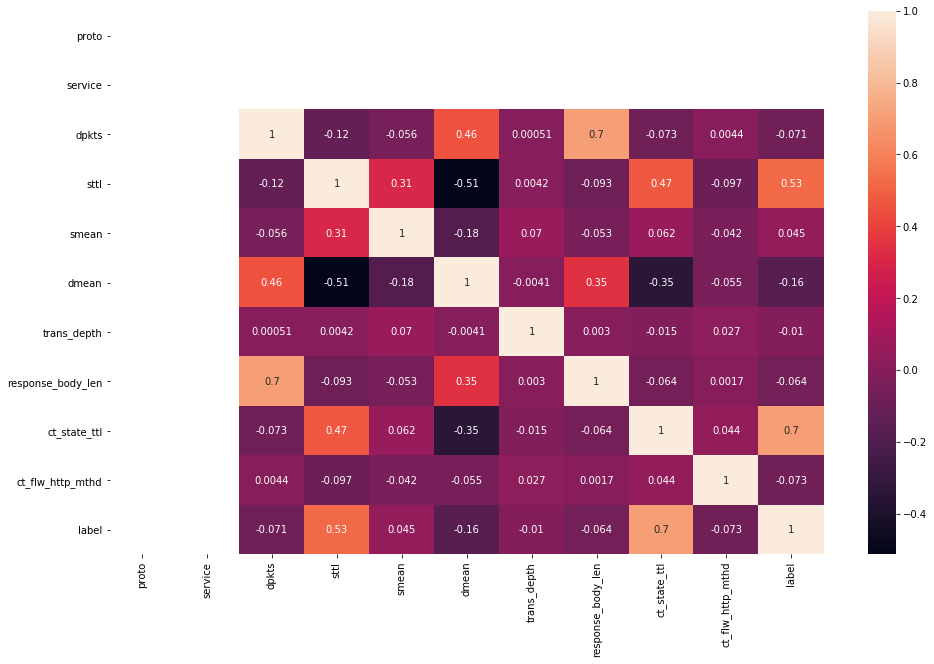

In [23]:
plt.figure(figsize=(16,10))
sns.heatmap(corr,annot=True)
plt.show()

# X & Y Selection

In [24]:
data_x = combined_data_reduced.drop(['label'], axis=1) # droped label
data_y = combined_data_reduced.loc[:,['label']]

In [25]:
data_x.head()

,proto,service,dpkts,sttl,smean,dmean,trans_depth,response_body_len,ct_state_ttl,ct_flw_http_mthd
35,0,0,8.0,62.0,82.0,147.0,1.0,184.0,1.0,1.0
40,0,0,10.0,62.0,83.0,127.0,1.0,187.0,1.0,1.0
45,0,0,8.0,62.0,83.0,142.0,1.0,165.0,1.0,1.0
49,0,0,10.0,62.0,80.0,141.0,1.0,261.0,1.0,1.0
72,0,0,8.0,62.0,75.0,140.0,1.0,157.0,1.0,1.0


In [26]:
data_y.tail()

,label
174998,1.0
175039,1.0
175076,1.0
175138,1.0
175214,1.0


In [27]:
X = data_x
y = data_y

In [28]:
# printing the number of samples

print('majority class: %d' % np.sum(y == 1))
print('minority class: %d' % np.sum(y == 0))

majority class: 17650
minority class: 9361


# Balanced Data Check

In [29]:
combined_data_reduced.isnull().values.any()

False

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'USNW_NB-15')

([<matplotlib.axis.XTick at 0x1d381f4b108>,
 <a list of 2 Text xticklabel objects>)

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Frequency')

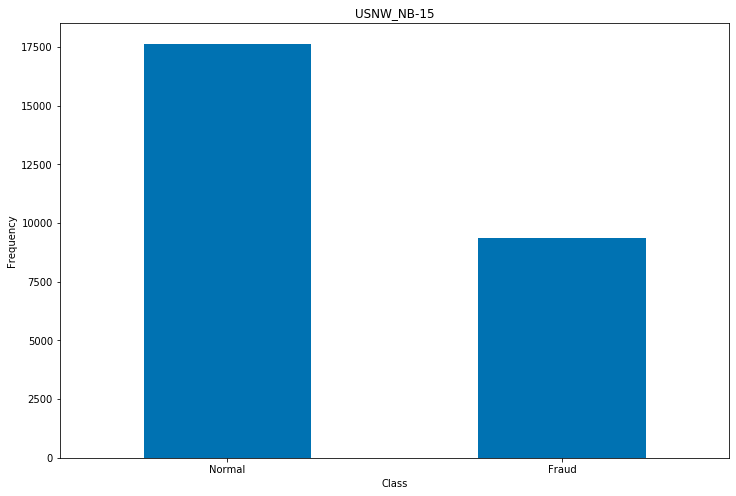

In [30]:
plt.figure(figsize=(12,8))

LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(combined_data_reduced['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("USNW_NB-15")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [31]:
## Get the Fraud and the normal dataset 

fraud = combined_data_reduced[combined_data_reduced['label']==0]

normal = combined_data_reduced[combined_data_reduced['label']==1]

In [32]:
print(fraud.shape,normal.shape)

(9361, 11) (17650, 11)


In [33]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [34]:
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_sample(X,y)

In [35]:
X_res.shape,y_res.shape

((35078, 10), (35078, 1))

In [36]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({'label': 1})
Resampled dataset shape Counter({'label': 1})


In [37]:
cmb = pd.concat([X_res,y_res])

In [38]:
cmb.head()

,proto,service,dpkts,sttl,smean,dmean,trans_depth,response_body_len,ct_state_ttl,ct_flw_http_mthd,label
0,0.0,0.0,8.0,62.0,82.0,147.0,1.0,184.0,1.0,1.0,NaN
1,0.0,0.0,10.0,62.0,83.0,127.0,1.0,187.0,1.0,1.0,NaN
2,0.0,0.0,8.0,62.0,83.0,142.0,1.0,165.0,1.0,1.0,NaN
3,0.0,0.0,10.0,62.0,80.0,141.0,1.0,261.0,1.0,1.0,NaN
4,0.0,0.0,8.0,62.0,75.0,140.0,1.0,157.0,1.0,1.0,NaN


In [39]:
cmb.isnull().values.any()

True

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'USNW_NB-15')

([<matplotlib.axis.XTick at 0x1d3824bd388>,
 <a list of 2 Text xticklabel objects>)

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Frequency')

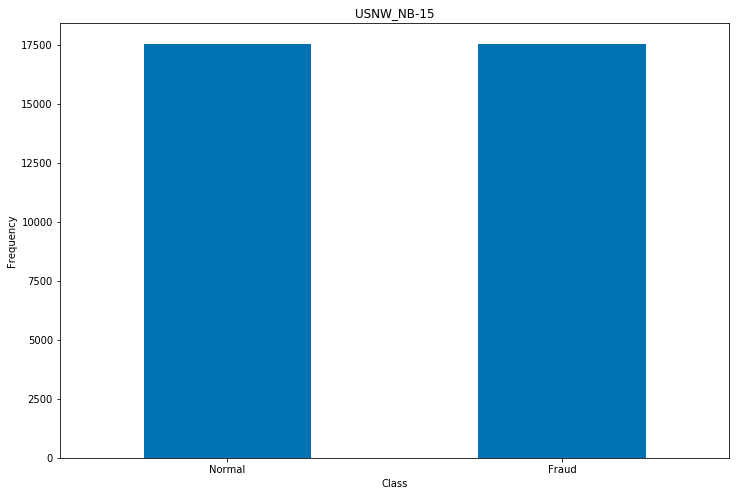

In [40]:
plt.figure(figsize=(12,8))

LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(cmb['label'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("USNW_NB-15")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [41]:
from imblearn.over_sampling import SMOTE, ADASYN

# Train - Test - Split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.50, random_state=42) # TODO

In [43]:
print(X_train)

       proto  service  dpkts   sttl  smean  dmean  trans_depth  \
9818       0        0   18.0   31.0  132.0  565.0          1.0   
9820       0        0   18.0   31.0  120.0  565.0          1.0   
34872      0        0    8.0   62.0   84.0  137.0          1.0   
21465      0        0   24.0   62.0   99.0  944.0          1.0   
31521      0        0   18.0   31.0  132.0  565.0          1.0   
...      ...      ...    ...    ...    ...    ...          ...   
16850      0        0    6.0  254.0   51.0   45.0          1.0   
6265       0        0   12.0  254.0  114.0  208.0          0.0   
11284      0        0   18.0   31.0  132.0  565.0          1.0   
860        0        0    6.0  254.0  157.0   45.0          1.0   
15795      0        0    8.0   62.0   79.0  164.0          1.0   

       response_body_len  ct_state_ttl  ct_flw_http_mthd  
9818              3924.0           0.0               1.0  
9820              3924.0           0.0               1.0  
34872              142.0      

# Feature Scaling

In [44]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [45]:
print(X_train)

[[ 0.          0.         -0.14129632 ... -0.12052584 -1.51504778
  -0.15729852]
 [ 0.          0.         -0.14129632 ... -0.12052584 -1.51504778
  -0.15729852]
 [ 0.          0.         -0.1949745  ... -0.14639278  0.65021083
   1.6153535 ]
 ...
 [ 0.          0.         -0.14129632 ... -0.12052584 -1.51504778
  -0.15729852]
 [ 0.          0.         -0.20571014 ... -0.14736399  0.65021083
  -0.15729852]
 [ 0.          0.         -0.1949745  ... -0.14570883  0.65021083
  -0.15729852]]


In [46]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(17539, 10)

(17539, 1)

(17539, 10)

(17539, 1)

# Overfitting vs Underfitting 

In [91]:
clf_1 = RandomForestClassifier(n_estimators=25, bootstrap=True, random_state=1)
clf_1.fit(X_train, y_train)
# Number of folds for cross validation
num_folds = 10

RandomForestClassifier(n_estimators=25, random_state=1)

In [92]:
clf_1_pred = clf_1.predict(X_test)

In [93]:
print("Accuracy:",metrics.accuracy_score(y_test, clf_1_pred)*100,"%")

Accuracy: 94.93699754832089 %


In [94]:
def plot_curve(ticks, train_scores, test_scores):
    train_scores_mean = -1 * np.mean(train_scores, axis=1)
    train_scores_std = -1 * np.std(train_scores, axis=1)
    test_scores_mean = -1 * np.mean(test_scores, axis=1)
    test_scores_std = -1 * np.std(test_scores, axis=1)

    plt.figure(figsize=(18,10))
    plt.fill_between(ticks, 
                     train_scores_mean - train_scores_std, 
                     train_scores_mean + train_scores_std, alpha=0.1, color="b")
    plt.fill_between(ticks, 
                     test_scores_mean - test_scores_std, 
                     test_scores_mean + test_scores_std, alpha=0.1, color="r")
    plt.plot(ticks, train_scores_mean, 'b-', label='Training score',marker='.')
    plt.plot(ticks, test_scores_mean, 'r-', label='Test score',marker='.')
    plt.legend(fancybox=True, facecolor='w')

    return plt.gca()

In [95]:
def plot_validation_curve(clf, X, y, param_name, param_range, scoring='roc_auc'):
    plt.xkcd()
    ax = plot_curve(param_range, *validation_curve(clf, X, y, cv=num_folds, 
                                                   scoring=scoring, 
                                                   param_name=param_name, 
                                                   param_range=param_range, n_jobs=-1))
    ax.set_title('')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlim(2,12)
    #ax.set_ylim(-1.00, -0.90)
    ax.set_ylim(-1.00, -0.925)
    ax.set_ylabel('Error')
    ax.set_xlabel('Model complexity')
    #ax.text(9, -0.94, 'Overfitting', fontsize=22)
    #ax.text(3, -0.94, 'Underfitting', fontsize=22)
    ax.text(9, -0.94, 'Overfitting', fontsize=22)
    ax.text(3, -0.94, 'Underfitting', fontsize=22)
    ax.axvline(7, ls='--')
    plt.tight_layout()

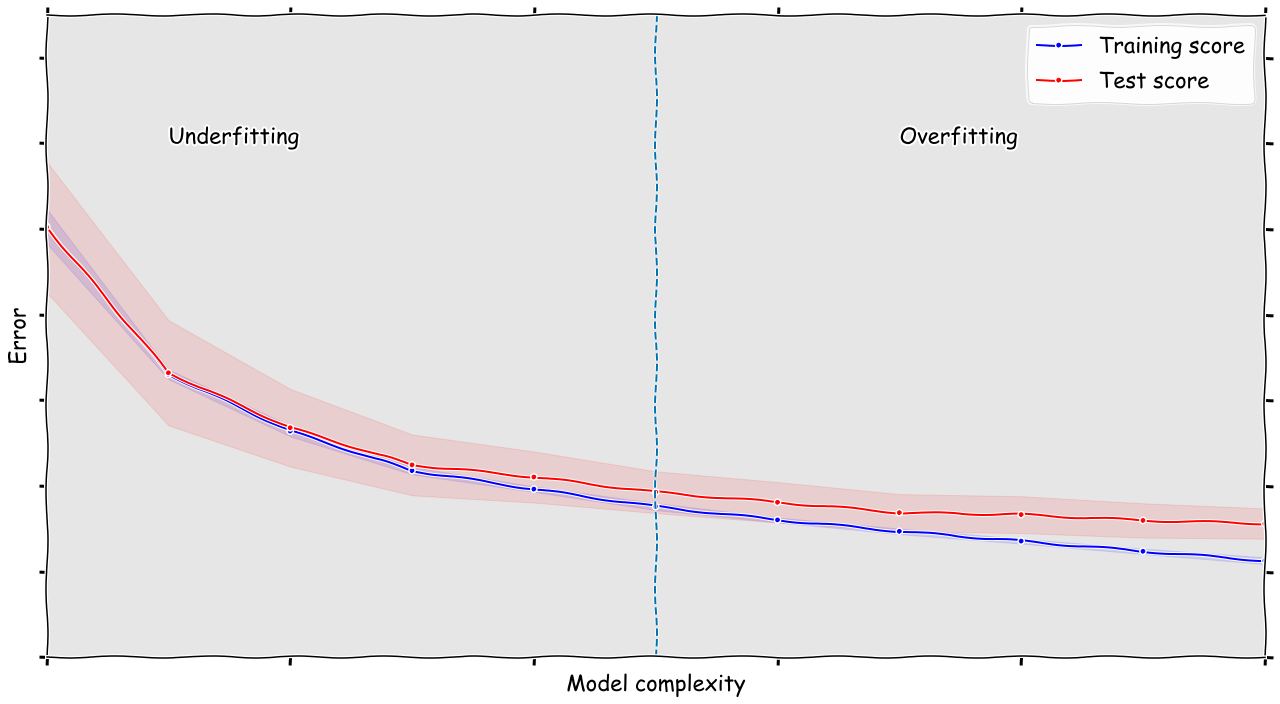

In [96]:
plot_validation_curve(clf_1, X_train, y_train, param_name='max_depth', param_range=range(2,13))

# Naive Bayes Classifier

In [47]:
NB_classifier = GaussianNB()
NB_classifier.fit(X_train, y_train)

GaussianNB()

In [48]:
# Predicting the Test set results
NB_pred = NB_classifier.predict(X_test)

In [49]:
print("Accuracy:",metrics.accuracy_score(y_test, NB_pred)*100,"%")

Accuracy: 74.7134956382918 %


In [56]:
print_confusion_matrix(y_test, NB_pred)

True  positive  =  8161
False positive  =  724
False negative  =  3711
True  negative  =  4943


In [57]:
results(y_test, NB_pred)

Accuracy:--> 74.7134956382918
F1-score:--> 69.03149221423085
DR:--------> 57.11809567829905
FAR:------->  8.14856499718627


# Support Vector Machine

In [50]:
#Create a svm Classifier
svm_clf = svm.SVC(kernel='linear') # Linear Kernel

In [51]:
#Train the model using the training sets
svm_clf.fit(X_train, y_train)

SVC(kernel='linear')

In [52]:
#Predict the response for test dataset
svm_pred = svm_clf.predict(X_test)

In [53]:
print("Accuracy:",metrics.accuracy_score(y_test, svm_pred)*100,"%")

Accuracy: 88.83630765722104 %


In [54]:
print_confusion_matrix(y_test, svm_pred)

True  positive  =  8501
False positive  =  384
False negative  =  1574
True  negative  =  7080


In [55]:
results(y_test, svm_pred)

Accuracy:--> 88.83630765722104
F1-score:--> 87.8520908301278
DR:--------> 81.81187889993066
FAR:------->  4.321890827236916


# Multi Layer Perceptron

In [58]:
MLP_clf = MLPClassifier(random_state=1, max_iter=25).fit(X_train, y_train)

In [59]:
MLP_pred = MLP_clf.predict(X_test)

In [60]:
print("Accuracy:",metrics.accuracy_score(y_test, MLP_pred)*100,"%")

Accuracy: 90.65511146587605 %


In [61]:
print_confusion_matrix(y_test, MLP_pred)

True  positive  =  8410
False positive  =  475
False negative  =  1164
True  negative  =  7490


In [62]:
results(y_test, MLP_pred)

Accuracy:--> 90.65511146587605
F1-score:--> 90.13779409110056
DR:--------> 86.5495724520453
FAR:------->  5.346088913899831


# Decision Tree

In [63]:
dtree = DecisionTreeClassifier()

In [64]:
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

In [65]:
dtree_pred = dtree.predict(X_test)

In [66]:
print("Accuracy:",metrics.accuracy_score(y_test, dtree_pred)*100,"%")

Accuracy: 94.41815382861053 %


In [67]:
print_confusion_matrix(y_test, dtree_pred)

True  positive  =  8383
False positive  =  502
False negative  =  477
True  negative  =  8177


In [68]:
results(y_test, dtree_pred)

Accuracy:--> 94.41815382861053
F1-score:--> 94.35181445797033
DR:--------> 94.48809798936908
FAR:------->  5.6499718626899265


## Decison Tree - 10-Fold Cross Validation

In [69]:
accuracies = cross_val_score(estimator = dtree, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 94.04 %
Standard Deviation: 0.27 %


# Random Forest Classifier

In [70]:
rfc = RandomForestClassifier(n_estimators=25, random_state=1)

In [71]:
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=25, random_state=1)

In [72]:
rfc_pred = rfc.predict(X_test)

In [73]:
print("Accuracy:",metrics.accuracy_score(y_test, rfc_pred)*100,"%")

Accuracy: 94.93699754832089 %


In [74]:
print_confusion_matrix(y_test, rfc_pred)

True  positive  =  8492
False positive  =  393
False negative  =  495
True  negative  =  8159


In [75]:
results(y_test, rfc_pred)

Accuracy:--> 94.93699754832089
F1-score:--> 94.83900964779728
DR:--------> 94.28010168708111
FAR:------->  4.423185143500281


## Random Forest Classifier - 10-Fold Cross Validation

In [76]:
accuracies = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 94.69 %
Standard Deviation: 0.33 %


# Ensemble Method

In [54]:
Image(url='https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_1_joyt3x.png')

# Different Types of Ensemble

In [55]:
Image(url='https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1542651255/image_2_pu8tu6.png')

# Logit Boost

In [77]:
lboost = LogitBoost(n_estimators=200, random_state=1)
lboost.fit(X_train, y_train)

LogitBoost(n_estimators=200, random_state=1)

In [78]:
LB_train = lboost.predict(X_train)
LB_test = lboost.predict(X_test)

accuracy_train = accuracy_score(y_train, LB_train)
accuracy_test = accuracy_score(y_test, LB_test)

#print('Training accuracy: %.4f' % accuracy_train)
#print('Test accuracy:     %.4f' % accuracy_test)
print('Training accuracy: ' , accuracy_train*100,"%")
print('Test accuracy    : ' , accuracy_test*100,"%")

Training accuracy:  93.7225611494384 %
Test accuracy    :  93.9164148469126 %


In [79]:
report_train = classification_report(y_train, LB_train)
report_test = classification_report(y_test, LB_test)
print('Training\n%s' % report_train)
print('Testing\n%s' % report_test)

Training
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      8654
         1.0       0.95      0.93      0.94      8885

    accuracy                           0.94     17539
   macro avg       0.94      0.94      0.94     17539
weighted avg       0.94      0.94      0.94     17539

Testing
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94      8885
         1.0       0.95      0.93      0.94      8654

    accuracy                           0.94     17539
   macro avg       0.94      0.94      0.94     17539
weighted avg       0.94      0.94      0.94     17539



In [80]:
print_confusion_matrix(y_test, LB_test)

True  positive  =  8438
False positive  =  447
False negative  =  620
True  negative  =  8034


In [81]:
results(y_test, LB_test)

Accuracy:--> 93.9164148469126
F1-score:--> 93.772979282171
DR:--------> 92.83568292119251
FAR:------->  5.030951041080472


## Visualizing Accuracy During Boosting

<Figure size 1080x576 with 0 Axes>

Text(0.5, 0, 'Iteration')

Text(0, 0.5, 'Accuracy')

Text(0.5, 1.0, 'Ensemble accuracy during each boosting iteration')

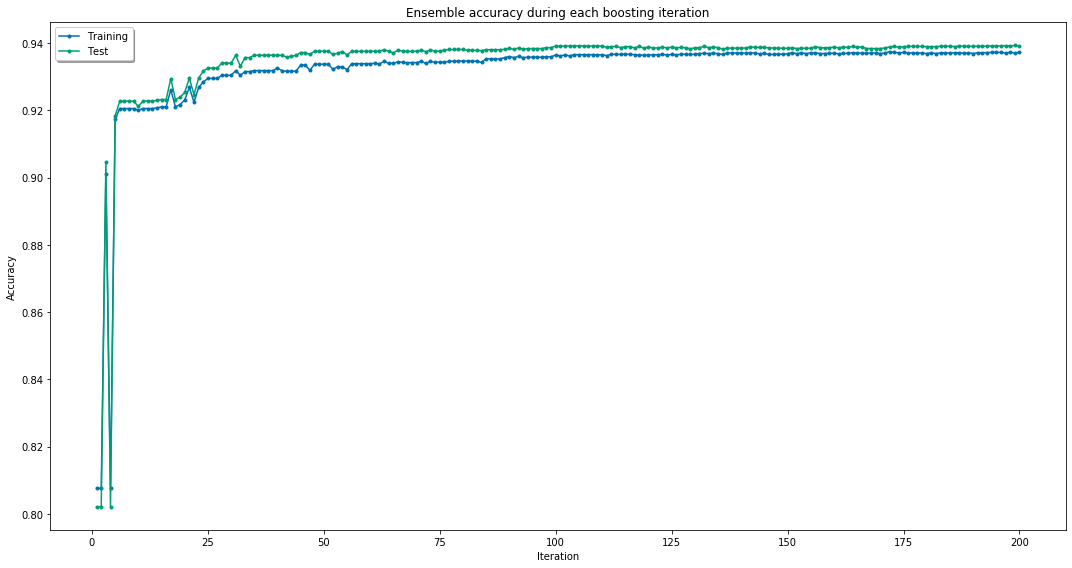

In [82]:
iterations = np.arange(1, lboost.n_estimators + 1)
staged_accuracy_train = list(lboost.staged_score(X_train, y_train))
staged_accuracy_test = list(lboost.staged_score(X_test, y_test))

plt.figure(figsize=(15,8))
plt.plot(iterations, staged_accuracy_train, label='Training', marker='.')
plt.plot(iterations, staged_accuracy_test, label='Test', marker='.')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Ensemble accuracy during each boosting iteration')
plt.legend(loc='best', shadow=True, frameon=True)

plt.tight_layout()
plt.show()
plt.close()

# Random Forest + Logit Boost + Ada Boost --- Ensemble -- 10 Fold Cross Validation

In [83]:
X = X_train
y = y_train

In [84]:
clf1 = RandomForestClassifier(n_estimators=100, random_state=5)
clf2 = LogitBoost(n_estimators=300, random_state=1)
clf3 = AdaBoostClassifier(n_estimators=300, random_state=1)

In [80]:
eclf = VotingClassifier(
        estimators=[('rf', clf1), ('lb', clf2), ('ad', clf3)],
        voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Random Forest', 'Logit Boost', 'Ada Boost', 'Ensemble']):
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
        print("Accuracy: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.9494 (+/- 0.00) [Random Forest]
Accuracy: 0.9434 (+/- 0.00) [Logit Boost]
Accuracy: 0.9439 (+/- 0.00) [Ada Boost]
Accuracy: 0.9466 (+/- 0.00) [Ensemble]


In [85]:
eclf = VotingClassifier(
        estimators=[('rf', clf1), ('lb', clf2)],
        voting='hard')

for clf, label in zip([clf1, clf2, eclf], ['Random Forest', 'Logit Boost', 'Ensemble']):
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
        print("Accuracy: %0.4f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.9471 (+/- 0.00) [Random Forest]
Accuracy: 0.9358 (+/- 0.00) [Logit Boost]
Accuracy: 0.9408 (+/- 0.00) [Ensemble]


# Graphical Representation of --> 

# Random-Forest + AdaBoost + LogitBoost --> Ensemble

In [86]:
eclf = VotingClassifier(estimators=[('rf', clf1), ('lb', clf2), ('ad', clf3)],
                        voting='soft',
                        weights=[5, 1, 1])

In [87]:
# predict class probabilities for all classifiers
probas = [c.fit(X, y).predict_proba(X) for c in (clf1, clf2, clf3, eclf)]

In [88]:
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

[Text(0, 0, 'RandomForestClassifier\nweight 5'),
 Text(0, 0, 'LogitBoost\nweight 1'),
 Text(0, 0, 'AdaBoost\nweight 1'),
 Text(0, 0, 'Ensemble Classifier\n(average probabilities)')]

(0, 1)

Text(0.5, 1.0, 'Class probabilities for sample 1 by different classifiers')

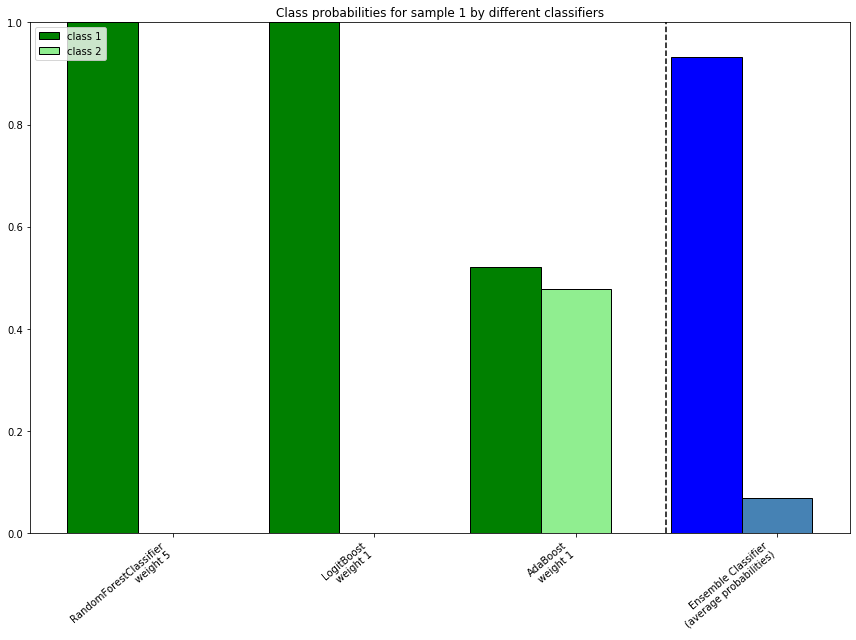

In [89]:
# plotting

N = 4  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig,ax = plt.subplots(figsize=(12,9))

# bars for classifier 1-3
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), width,
            color='green', edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), width,
            color='lightgreen', edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, 0, class1_1[-1]], width,
            color='blue', edgecolor='k')
p4 = ax.bar(ind + width, [0, 0, 0, class2_1[-1]], width,
            color='steelblue', edgecolor='k')

# plot annotations
plt.axvline(2.8, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
ax.set_xticklabels(['RandomForestClassifier\nweight 5',
                    'LogitBoost\nweight 1',
                    'AdaBoost\nweight 1',
                    'Ensemble Classifier\n(average probabilities)'],
                   rotation=40,
                   ha='right')
plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.show()